In [1]:
from Bio.Align import substitution_matrices
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
import sys
import os

sys.path.append(os.path.abspath('..'))
from utils.augmentation.augment_functions import augment_sequence

h:\study\6\ML\project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


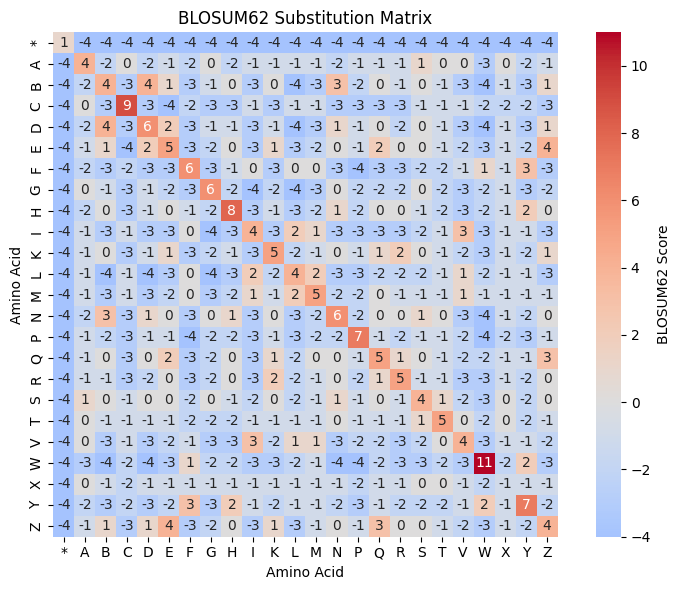

In [2]:
blosum62 = substitution_matrices.load("BLOSUM62")
blosum_amino_acids = sorted(blosum62.alphabet)

matrix = np.zeros((len(blosum_amino_acids), len(blosum_amino_acids)))
for i, aa1 in enumerate(blosum_amino_acids):
    for j, aa2 in enumerate(blosum_amino_acids):
        matrix[i, j] = blosum62[aa1][aa2]

plt.figure(figsize=(8, 6))
sns.heatmap(
    matrix,
    xticklabels=blosum_amino_acids,
    yticklabels=blosum_amino_acids,
    cmap="coolwarm",
    center=0,
    square=True,
    annot=True,
    fmt=".0f",
    cbar_kws={"label": "BLOSUM62 Score"},
)

plt.title("BLOSUM62 Substitution Matrix")
plt.xlabel("Amino Acid")
plt.ylabel("Amino Acid")
plt.tight_layout()
plt.show()

In [3]:
original_seq = "MAKVRTKDVMEQFNLELISGEEGINRPITMSDLSRPGIEIAGYFTYYPRERVQLLGK"
new_seqs, _ = augment_sequence(
    original_seq,
    num_substitutions=[1, 2, 3],
    num_mutations=[3, 2, 1],
    min_score=0,
    max_hydro_diff=1,
    random_seed=41,
)

print(f"Original Sequence: {original_seq}")
print("-" * 50)
for i, seq in enumerate(new_seqs, 1):
    # Find positions where the sequence differs
    diffs = [j for j, (a, b) in enumerate(zip(original_seq, seq)) if a != b]
    print(f"\n Augmented Sequence {i}: {seq}")
    print(f"Changes: {len(diffs)} substitutions at positions {diffs}")
print("-" * 50)
print(f"Total Augmented Sequences: {len(new_seqs)}")

Original Sequence: MAKVRTKDVMEQFNLELISGEEGINRPITMSDLSRPGIEIAGYFTYYPRERVQLLGK
--------------------------------------------------

 Augmented Sequence 1: MAKVRTKDVMEQFNLELISGEEGIRRPITMSDLSRPGIEIAGYFTYYPRERVQLLGK
Changes: 1 substitutions at positions [24]

 Augmented Sequence 2: MAKVRTKDVMEQFNFELISGEEGINRPITMSDLSRPGIEIAGYFTYYPRERVQLLGK
Changes: 1 substitutions at positions [14]

 Augmented Sequence 3: MAKVRTKDVMEQFNLELISGEEGIQRPITMSDLSRPGIEIAGYFTYYPRERVQLLGK
Changes: 1 substitutions at positions [24]

 Augmented Sequence 4: MAKVRTKDVMEQFNLELVSGEEGINRPITMSDLSRPGIEIAGYFTYYPRERVQLLGK
Changes: 1 substitutions at positions [17]

 Augmented Sequence 5: MAKVRTKDVMEQFNLELISGEEGINRPITMSDLSRPGIEIAGYFTYWPRERVQLVGK
Changes: 2 substitutions at positions [46, 54]

 Augmented Sequence 6: MAKVRTKDVMEQFNLZLISGEEGINRPITMSDLSRPGIEIAGWFTYYPRDRVQLLGK
Changes: 3 substitutions at positions [15, 42, 49]
--------------------------------------------------
Total Augmented Sequences: 6


In [4]:
def plot_pca_clusters(pca_result, sequences, augmented_sequences, colors):
    plt.figure(figsize=(8, 6))

    offset = 0
    for i, (seq, aug_seqs, color) in enumerate(
        zip(sequences, augmented_sequences, colors)
    ):
        # Plot original sequence
        plt.scatter(
            pca_result[offset, 0],
            pca_result[offset, 1],
            c=color,
            marker="*",
            s=200,
            label=f"Original Sequence {i+1}",
        )

        # Plot augmented sequences
        for j in range(1, len(aug_seqs) + 1):
            plt.scatter(
                pca_result[offset + j, 0],
                pca_result[offset + j, 1],
                c=color,
                alpha=0.6,
                s=40,
                label=f"Augmented Sequence {i+1}" if j == 1 else None,
            )

        offset += len(aug_seqs) + 1

    plt.title("PCA of Protein Sequence Embeddings")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()


def get_embeddings(sequences, tokenizer, model, device):
    embeddings = []
    for seq in sequences:
        inputs = tokenizer(seq, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).cpu()
        embeddings.append(embedding)
    return torch.cat(embeddings, dim=0).numpy()

Using device: cuda


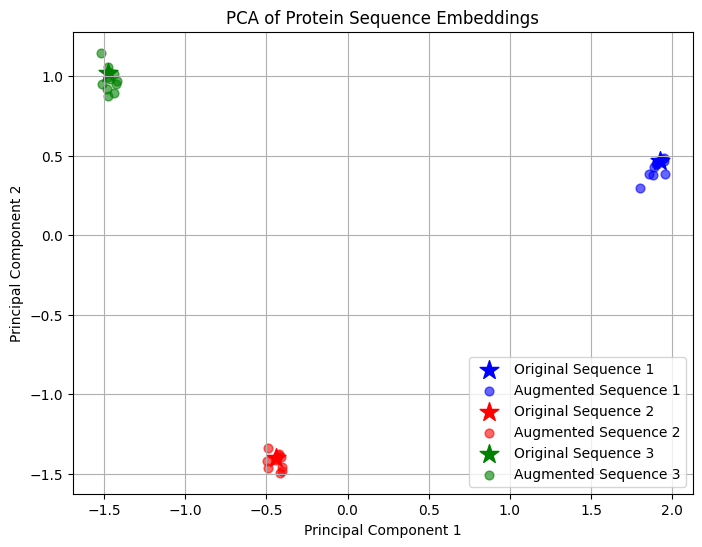

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = AutoModel.from_pretrained(
    "facebook/esm2_t6_8M_UR50D", add_pooling_layer=False
).to(device)

# Sequences
sequences = [
    "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG",
    "MAKVRTKDVMEQFNLELISGEEGINRPITMSDLSRPGIEIAGYFTYYPRERVQLLGK",
    "MGSSHHHHHHSSGLVPRGSHMASMTGGQQMGRGSEFDDDDKMQTIEEVLHKAIELAKVGVDSVEEAKKVLAKLLDKEK",
]

# Generate augmented sequences
aug_params = {
    "num_substitutions": [1, 2, 3],
    "num_mutations": [5, 4, 3],
    "min_score": 0,
    "max_hydro_diff": 1,
    "random_seed": 42,
}

augmented_sequences = [augment_sequence(seq, **aug_params)[0] for seq in sequences]

all_sequences = []
for seq, aug_seqs in zip(sequences, augmented_sequences):
    all_sequences.extend([seq] + aug_seqs)

embeddings = get_embeddings(all_sequences, tokenizer, model, device)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

plot_pca_clusters(pca_result, sequences, augmented_sequences, ["blue", "red", "green"])

cuda


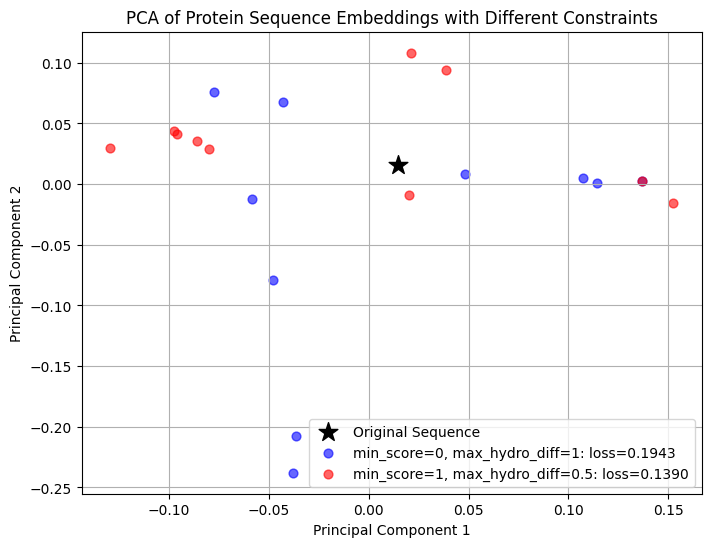

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D", add_pooling_layer=False)
model = model.to(device)

sequence = "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"

# Generate single point augmented sequences with different constraints
augmented_sequences1, _ = augment_sequence(
    sequence,
    num_substitutions=[1, 2, 3],
    num_mutations=[10, 0, 0],
    min_score=0,
    max_hydro_diff=1,
    random_seed=42,
)

augmented_sequences2, _ = augment_sequence(
    sequence,
    num_substitutions=[1, 2, 3],
    num_mutations=[10, 0, 0],
    min_score=3,
    max_hydro_diff=0.5,
    random_seed=42,
)

# Get embeddings for original sequence
original_inputs = tokenizer(sequence, return_tensors="pt").to(device)
with torch.no_grad():
    original_outputs = model(**original_inputs)
original_embedding = original_outputs.last_hidden_state.mean(dim=1).cpu()

# Get embeddings for first set of augmented sequences
embeddings1 = []
for seq in augmented_sequences1:
    inputs = tokenizer(seq, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).cpu()
    embeddings1.append(embedding)

# Get embeddings for second set of augmented sequences
embeddings2 = []
for seq in augmented_sequences2:
    inputs = tokenizer(seq, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).cpu()
    embeddings2.append(embedding)


# Define loss as L2 norm differences between original and augmented embeddings
def difference_from_original(embeddings, original_embedding):
    differences = []
    for embedding in embeddings:
        diff = embedding.numpy() - original_embedding.numpy()
        diff = np.linalg.norm(diff, axis=1)
        differences.append(diff)
    return sum(differences)[0] / len(differences)


loss1 = difference_from_original(embeddings1, original_embedding)
loss2 = difference_from_original(embeddings2, original_embedding)

# Combine embeddings for PCA
combined_embeddings = torch.cat(
    [original_embedding] + embeddings1 + embeddings2, dim=0
).numpy()

pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(
    pca_result[0, 0],
    pca_result[0, 1],
    c="black",
    marker="*",
    s=200,
    label="Original Sequence",
)

offset1 = 1
offset2 = len(augmented_sequences1) + 1

for i in range(len(augmented_sequences1)):
    plt.scatter(
        pca_result[offset1 + i, 0],
        pca_result[offset1 + i, 1],
        c="blue",
        alpha=0.6,
        s=40,
        label=(
            f"min_score=0, max_hydro_diff=1: loss={loss1:.4f}"
            if i == 0
            else None
        ),
    )

for i in range(len(augmented_sequences2)):
    plt.scatter(
        pca_result[offset2 + i, 0],
        pca_result[offset2 + i, 1],
        c="red",
        alpha=0.6,
        s=40,
        label=(
            f"min_score=1, max_hydro_diff=0.5: loss={loss2:.4f}"
            if i == 0
            else None
        ),
    )

plt.title("PCA of Protein Sequence Embeddings with Different Constraints")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

cuda


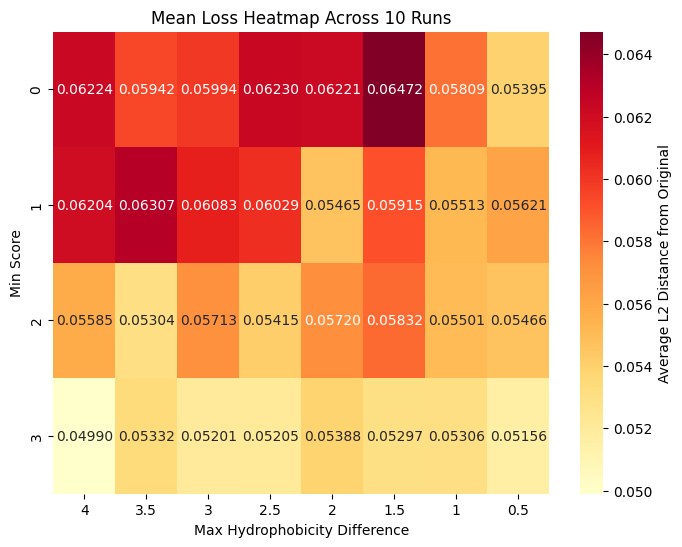

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D", add_pooling_layer=False)
model = model.to(device)

sequence = "MAKVRTKDVMEQFNLELISGEEGINRPITMSDLSRPGIEIAGYFTYYPRERVQLLGKTELSFFEQLPEEEKKQRMDSLCTDVTPAIILSRDMPIPQELIDASEKNGVPVLRSPLKTTRLSSRLTNFLESRLAPTTAIHGVLVDIYGVGVLITGKSGVGKSETALELVKRGHRLVADDCVEIRQEDQDTLVGNAPELIEHLLEIRGLGIINVMTLFGAGAVRSNKRITIVMNLELWEQGKQYDRLGLEEETMKIIDTEITKLTIPVRPGRNLAVIIEVAAMNFRLKRMGLNAAEQFTNKLADVIEDGEQEE"

min_scores = [0, 1, 2, 3]
max_hydro_diffs = [4, 3.5, 3, 2.5, 2, 1.5, 1, 0.5]

# Get embeddings for original sequence
original_inputs = tokenizer(sequence, return_tensors="pt").to(device)
with torch.no_grad():
    original_outputs = model(**original_inputs)
original_embedding = original_outputs.last_hidden_state.mean(dim=1).cpu()


# Calculate L2 norm differences between original and augmented embeddings
def difference_from_original(embeddings, original_embedding):
    differences = []
    for embedding in embeddings:
        diff = embedding.numpy() - original_embedding.numpy()
        diff = np.linalg.norm(diff, axis=1)
        differences.append(diff)
    return sum(differences)[0] / len(differences)


# Initialize arrays to store results for ensemble averaging
num_runs = 10
all_loss_matrices = np.zeros((num_runs, len(min_scores), len(max_hydro_diffs)))

# Run experiments with different random seeds
for run in range(num_runs):
    loss_matrix = np.zeros((len(min_scores), len(max_hydro_diffs)))

    for i, min_score in enumerate(min_scores):
        for j, max_hydro_diff in enumerate(max_hydro_diffs):
            augmented_sequences, _ = augment_sequence(
                sequence,
                num_substitutions=[1, 2, 3],
                num_mutations=[10, 0, 0],
                min_score=min_score,
                max_hydro_diff=max_hydro_diff,
            )

            embeddings = []
            for seq in augmented_sequences:
                inputs = tokenizer(seq, return_tensors="pt").to(device)
                with torch.no_grad():
                    outputs = model(**inputs)
                embedding = outputs.last_hidden_state.mean(dim=1).cpu()
                embeddings.append(embedding)

            loss = difference_from_original(embeddings, original_embedding)
            loss_matrix[i, j] = loss

    all_loss_matrices[run] = loss_matrix
# Calculate mean across runs
mean_loss_matrix = np.mean(all_loss_matrices, axis=0)

# Create single figure
plt.figure(figsize=(8, 6))

# Plot mean heatmap
sns.heatmap(
    mean_loss_matrix,
    annot=True,
    fmt=".5f",
    cmap="YlOrRd",
    xticklabels=max_hydro_diffs,
    yticklabels=min_scores,
    cbar_kws={"label": "Average L2 Distance from Original"},
)
plt.title("Mean Loss Heatmap Across 10 Runs")
plt.xlabel("Max Hydrophobicity Difference")
plt.ylabel("Min Score")
plt.show()

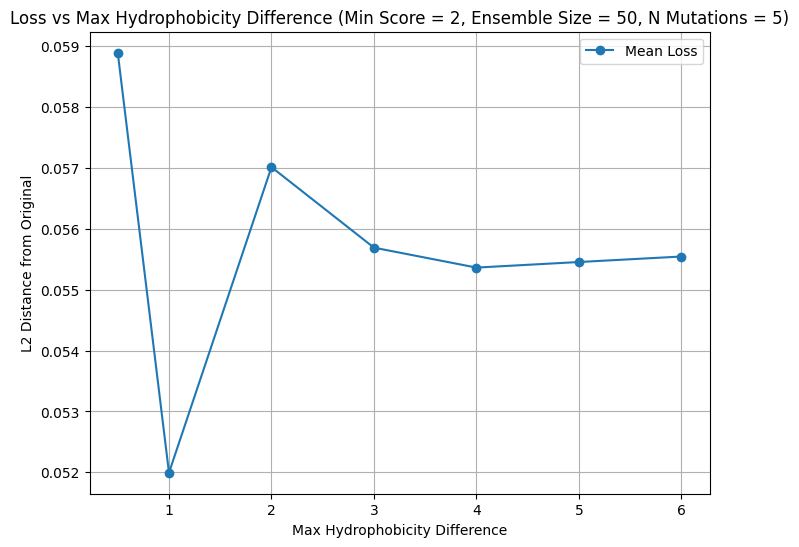

In [8]:
# Fix min_score to 3 and plot loss vs max_hydro_diff with ensemble averaging
fixed_min_score = 2
num_runs = 50
max_hydro_diffs = [0.5, 1, 2, 3, 4, 5, 6]
all_losses = np.zeros((num_runs, len(max_hydro_diffs)))
num_mutations = [5, 0, 0]

# Ensemble averaging
for run in range(num_runs):
    losses = []
    for i, max_hydro_diff in enumerate(max_hydro_diffs):
        augmented_sequences, _ = augment_sequence(
            sequence,
            num_substitutions=[1, 2, 3],
            num_mutations=num_mutations,
            min_score=fixed_min_score,
            max_hydro_diff=max_hydro_diff,
        )

        embeddings = []
        for seq in augmented_sequences:
            inputs = tokenizer(seq, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = model(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1).cpu()
            embeddings.append(embedding)

        loss = difference_from_original(embeddings, original_embedding)
        losses.append(loss)

    all_losses[run] = losses
mean_losses = np.mean(all_losses, axis=0)

plt.figure(figsize=(8, 6))
plt.plot(max_hydro_diffs, mean_losses, marker="o", linestyle="-", label="Mean Loss")
plt.title(
    f"Loss vs Max Hydrophobicity Difference (Min Score = {fixed_min_score}, Ensemble Size = {num_runs}, N Mutations = {num_mutations[0]})"
)
plt.xlabel("Max Hydrophobicity Difference")
plt.ylabel("L2 Distance from Original")
plt.grid(True)
plt.legend()
plt.show()